In [274]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import scipy
import xgboost as xgb
import plotly.offline as py
import plotly.graph_objs as go

from bs4 import BeautifulSoup
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from sklearn.cluster import DBSCAN

## 1. Импорт и  первичный анализ данных

In [275]:
data = pd.read_csv('data/tea_demand.zip', delimiter=r"\s+")
data.head()

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185


In [276]:
data.date = pd.to_datetime(data.date) 

Предлагаю сделать фильтр по Ахмаду и убрать столбец brand_id

In [277]:
data_ahmat = data[data.brand_id==178].drop('brand_id', axis=1)
data_ahmat.reset_index(drop=True, inplace=True)

data_lipton = data[data.brand_id==29].drop('brand_id', axis=1)
data_lipton.reset_index(drop=True, inplace=True)

data_may = data[data.brand_id==5152].drop('brand_id', axis=1)
data_may.reset_index(drop=True, inplace=True)

In [278]:
data_ahmat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            153 non-null    datetime64[ns]
 1   receipts_count  153 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.5 KB


In [279]:
data_ahmat.describe()

,date,receipts_count
count,153,153.000000
mean,2016-09-15 00:00:00,327.045752
min,2016-07-01 00:00:00,143.000000
25%,2016-08-08 00:00:00,227.000000
50%,2016-09-15 00:00:00,275.000000
75%,2016-10-23 00:00:00,399.000000
max,2016-11-30 00:00:00,712.000000
std,NaN,134.810703


In [280]:
data_ahmat.date.head()

0   2016-07-01
1   2016-07-02
2   2016-07-03
3   2016-07-04
4   2016-07-05
Name: date, dtype: datetime64[ns]

Из первичного анализа видно, что необходима информация о играх, проводимых в 2016 году.

## 2. Импорт данных о играх

Как первый попавшийся по выдаче в гугл сайт берем https://www.toramp.com/schedule.php?id=3857

In [281]:
response = requests.get('https://www.toramp.com/schedule.php?id=3857')
soup = BeautifulSoup(response.text,'html.parser')

In [282]:
all_dates = soup.find_all('time', class_="nowrap")

In [283]:
games_dates =[]
for d in all_dates:
    if '2016' in d['datetime']:
        games_dates.append(d['datetime'])
        print(d['datetime'])
games_dates = pd.DataFrame({'date': pd.to_datetime(games_dates)})

2016-03-27
2016-04-03
2016-04-10
2016-04-17
2016-04-24
2016-05-15
2016-05-22
2016-05-29
2016-06-05
2016-06-19
2016-09-25
2016-10-02
2016-10-09
2016-10-16
2016-10-23
2016-11-21
2016-11-28
2016-12-12
2016-12-19
2016-12-18


In [284]:
games_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    20 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 292.0 bytes


Так даты игр моут отсутствовать в датасете, предлагаю соединитьдатасеты data и games_dates

In [285]:
data_ahmat =  data_ahmat.join(games_dates.set_index('date'), on='date', how='left')
data_ahmat.reset_index(drop=True, inplace=True)
# data = pd.concat([data, games_dates], join='outer', axis=1)

In [286]:
data_ahmat

,date,receipts_count
0,2016-07-01,234
1,2016-07-02,185
2,2016-07-03,190
3,2016-07-04,196
4,2016-07-05,336
...,...,...
148,2016-11-26,238
149,2016-11-27,229
150,2016-11-28,267
151,2016-11-29,222


In [287]:
data_ahmat['games'] = data_ahmat.date.isin(games_dates.date)
print(data_ahmat.games.sum())
data_ahmat.head()

7


,date,receipts_count,games
0,2016-07-01,234,False
1,2016-07-02,185,False
2,2016-07-03,190,False
3,2016-07-04,196,False
4,2016-07-05,336,False


## 3. Разведывательный анализ данных

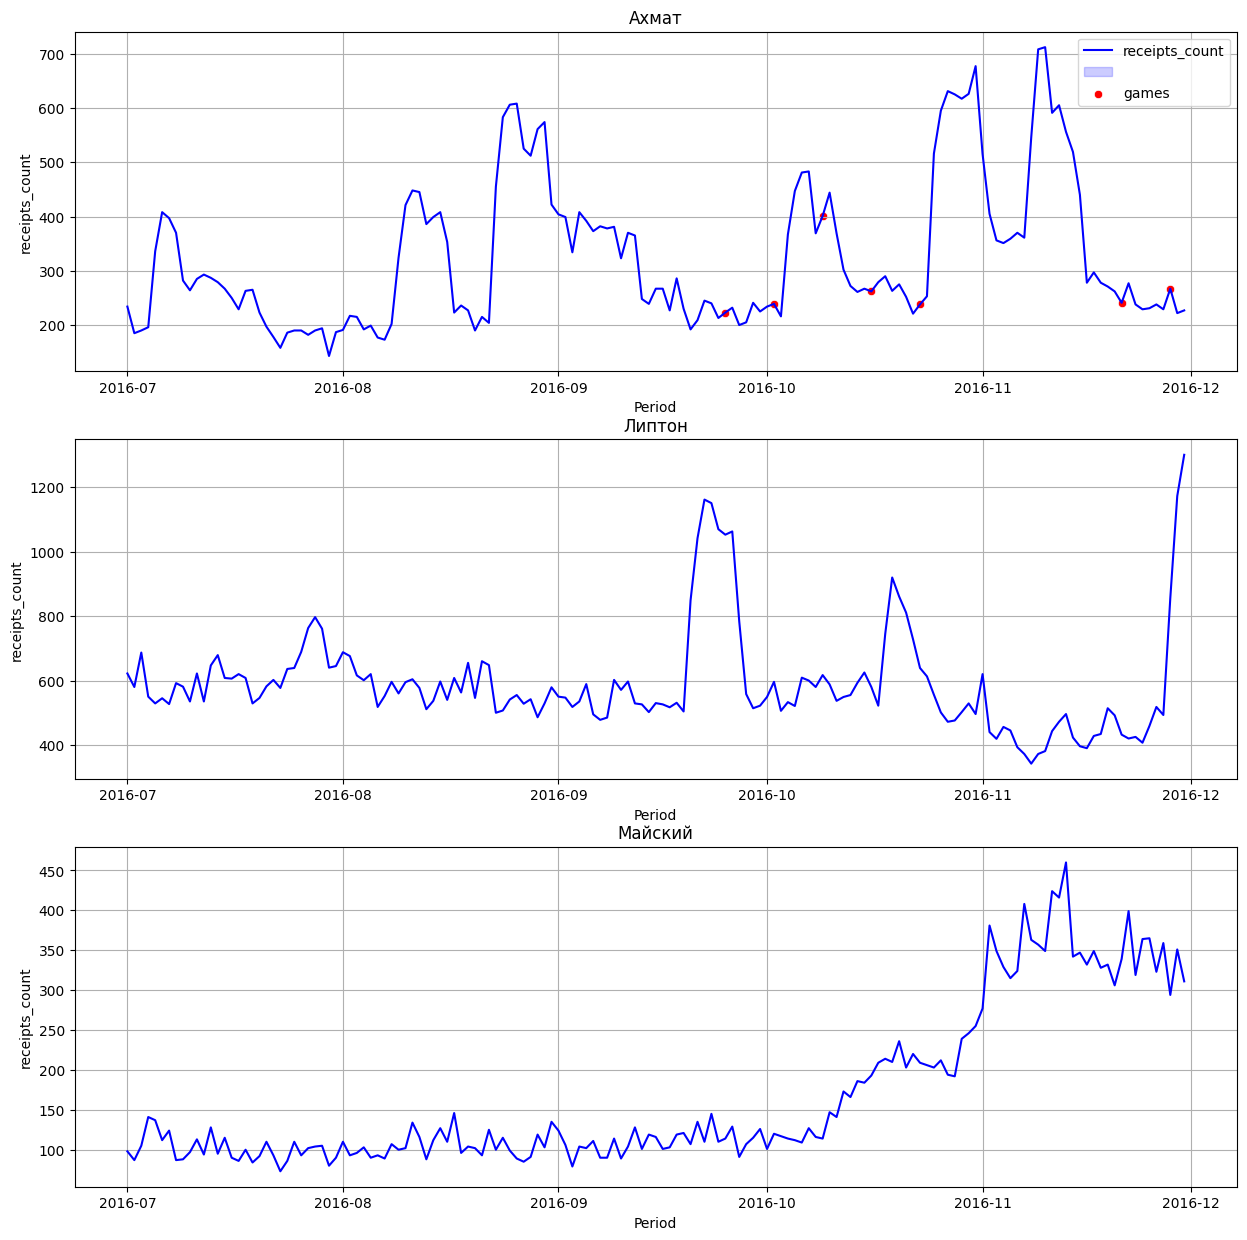

In [288]:
fig, axes = pyplot.subplots(nrows=3, figsize=(15, 15))

sns.lineplot(y=data_ahmat.receipts_count, x=data_ahmat.date, ax=axes[0], c='blue')
sns.scatterplot(y=data_ahmat[data_ahmat.games==True].games*data_ahmat.receipts_count, x=data_ahmat.date, ax=axes[0], c='red')
axes[0].legend(['receipts_count','', 'games'])
axes[0].set(xlabel='Period', ylabel='receipts_count', title="Ахмат")
axes[0].grid()

sns.lineplot(y=data_lipton.receipts_count, x=data_lipton.date, ax=axes[1], c='blue')
axes[1].set(xlabel='Period', ylabel='receipts_count', title="Липтон")
axes[1].grid()

sns.lineplot(y=data_may.receipts_count, x=data_may.date, ax=axes[2], c='blue')
axes[2].set(xlabel='Period', ylabel='receipts_count', title="Майский")
axes[2].grid()

Согласно ТЗ неизвестно когда началась реклама чая в передаче "Что?Где?Когда?". Игры были в 2016 году начиная с марта, но резкого роста продаж или пиков после игр на графике не наблюдается. Можно рассматривать в сравнении с Липтон, продажи которого с октября начали расти.

<Axes: ylabel='receipts_count'>

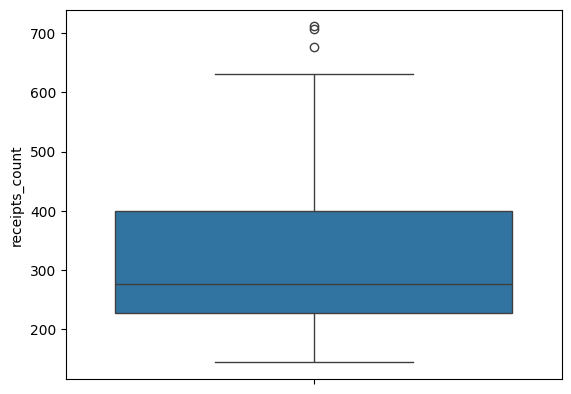

In [289]:
sns.boxplot(y=data_ahmat.receipts_count)

Исходя из коробчатой диаграммы имеем 3 выброса. 

In [290]:
iqr = scipy.stats.iqr(data_ahmat.receipts_count)
data_ahmat[(data_ahmat.receipts_count > (np.percentile(data_ahmat.receipts_count, 75)+1.5*iqr))]

,date,receipts_count,games
122,2016-10-31,677,False
131,2016-11-09,708,False
132,2016-11-10,712,False


Выбросы имеют место в период проведения игр. Так что влияние рекламы исключичать полностью нельзя.

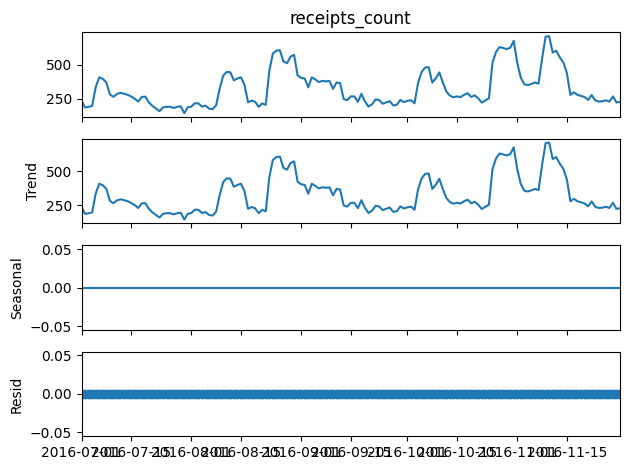

In [291]:
decomposition = seasonal_decompose(data_ahmat.set_index('date').receipts_count, model='additive', period=1) 
decomposition.plot()
pyplot.show() # любуемся результатом

In [292]:
trend_part = decomposition.trend # отдельно трендовая составляющаяя
seasonal_part = decomposition.seasonal # отдельно сезонная составляющаяя
residual_part = decomposition.resid # отдельно шум: то, что осталось

print(f'Элементов в исходном датасете: {len(data_ahmat.index)}')
print(f'Элементов в шумовой части: {len(residual_part)}')
print(f'Ненулевых элементов в шумовой части: {len(residual_part[residual_part != 0])}')
print(f'Элементов в сезонной части: {len(seasonal_part)}')
print(f'Ненулевых элементов в сезонной части: {len(seasonal_part[seasonal_part != 0])}')
print(f'Элементов в трендовой части: {len(trend_part)}')
print(f'Ненулевых элементов в трендовой части: {len(trend_part[trend_part != 0])}')

Элементов в исходном датасете: 153
Элементов в шумовой части: 153
Ненулевых элементов в шумовой части: 0
Элементов в сезонной части: 153
Ненулевых элементов в сезонной части: 0
Элементов в трендовой части: 153
Ненулевых элементов в трендовой части: 153


Сезонность и шум в графике отсутствуют.

## 4. Построение модели

Для начала предлагаю найти первую игру, на которой проводилась реклама и которя должна была повлиять на продажи.

In [293]:
data_ahmat[data_ahmat.games == True].iloc[0]

date              2016-09-25 00:00:00
receipts_count                    223
games                            True
Name: 86, dtype: object

Предлагаю выделить в тренировочную выборку данные до 9 сентября 2016 года, а потом посмотреть будет ли прогноз модели соответствовать реальному положению дел. Если будет, то логично предположить, что реклама не оказала воздействие на продажи.

Как модель предлагаю использовать XGBost.

Первым делом разделим датафрейм на обучающую и тестовую выборки.

In [294]:
train_df = data_ahmat[data_ahmat.date < '2016-09-25']
test_df = data_ahmat[data_ahmat.date >= '2016-09-25']
print(train_df.tail(), 2*'\n')
print(test_df.head())

         date  receipts_count  games
81 2016-09-20             192  False
82 2016-09-21             209  False
83 2016-09-22             245  False
84 2016-09-23             240  False
85 2016-09-24             213  False 


         date  receipts_count  games
86 2016-09-25             223   True
87 2016-09-26             232  False
88 2016-09-27             200  False
89 2016-09-28             205  False
90 2016-09-29             241  False


In [295]:
def create_features(df, label=None):
    """
    создаем признаки из datetime индекса
    """
    # df['date'] = df.index
    # df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [296]:
X_train, y_train = create_features(train_df, 'receipts_count')
X_test, y_test = create_features(test_df, 'receipts_count')
X_test.head()

C:\Users\zhigu\AppData\Local\Temp\ipykernel_17436\2014664948.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\zhigu\AppData\Local\Temp\ipykernel_17436\2014664948.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\zhigu\AppData\Local\Temp\ipykernel_17436\2014664948.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
86,6,3,9,2016,269,25,38
87,0,3,9,2016,270,26,39
88,1,3,9,2016,271,27,39
89,2,3,9,2016,272,28,39
90,3,3,9,2016,273,29,39


Обучаем модель.

In [297]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
xgb_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:86.92166	validation_1-rmse:163.97152
[1]	validation_0-rmse:65.70863	validation_1-rmse:167.05883


[2]	validation_0-rmse:50.17338	validation_1-rmse:168.87163
[3]	validation_0-rmse:38.84502	validation_1-rmse:168.84963
[4]	validation_0-rmse:30.36715	validation_1-rmse:168.69355
[5]	validation_0-rmse:24.20302	validation_1-rmse:169.73681
[6]	validation_0-rmse:19.26660	validation_1-rmse:170.55169
[7]	validation_0-rmse:15.50767	validation_1-rmse:171.12772
[8]	validation_0-rmse:12.41772	validation_1-rmse:171.75946
[9]	validation_0-rmse:10.39039	validation_1-rmse:172.29224
[10]	validation_0-rmse:8.49110	validation_1-rmse:172.64217
[11]	validation_0-rmse:7.00063	validation_1-rmse:172.98889
[12]	validation_0-rmse:5.89982	validation_1-rmse:172.95327
[13]	validation_0-rmse:5.00503	validation_1-rmse:173.49897
[14]	validation_0-rmse:4.11027	validation_1-rmse:173.89432
[15]	validation_0-rmse:3.47952	validation_1-rmse:173.82310
[16]	validation_0-rmse:2.90381	validation_1-rmse:174.05809
[17]	validation_0-rmse:2.45965	validation_1-rmse:174.15538
[18]	validation_0-rmse:2.15081	validation_1-rmse:174.420

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [298]:
y_test_pred_xgb = xgb_reg.predict(X_test)

In [299]:
py.iplot([
    go.Scatter(x=data_ahmat['date'], y=data_ahmat['receipts_count'], name='receipts_count'),
    go.Scatter(x=test_df['date'], y=y_test_pred_xgb, name='predicted'),
    ])

Для анализа применим медианное значение, так как есть выбросы

In [300]:
print('Медианное значение по продажам: ', test_df['receipts_count'].median())
print('Медианное значение предсказанное: ', pd.DataFrame(y_test_pred_xgb).median().values[0])

Медианное значение по продажам:  279.0
Медианное значение предсказанное:  281.59622


Данные говорят о том, что реклама не имела воздействия на продажи чая Ахмат.

## 5. Уточнение наличия выбросов во временном ряду во время рекламной акции

Строим коробчатую диаграмму в период проведения рекламной акции.

<Axes: ylabel='receipts_count'>

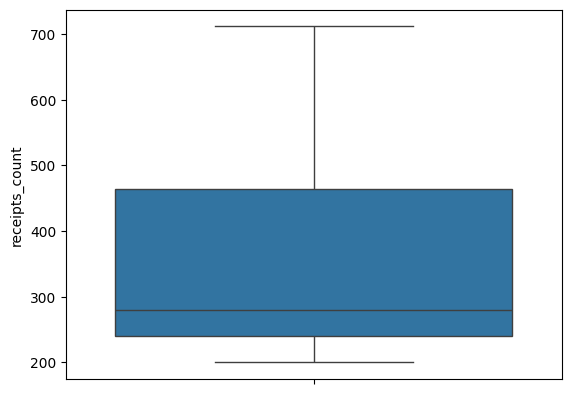

In [301]:
sns.boxplot(y=test_df.receipts_count)

Выбросы отсутствуют, что подтверждает предположение, что увеличения продаж во время рекламной акции не последовало. Хотя на мой взгляд это ни о чем и не говорит. Теоретически выбросы от рекламы должны читаться скорее на всем промежутке, чем в период проведения рекламной акции. Но ТЗ есть ТЗ.

Далее пробуем кластеризировать точки DBSCAN.

подбираем eps так, чтобы получилась единый кластер и выбросы.

In [302]:
dbscan = DBSCAN(eps=40)

In [303]:
data_ahmat['prediction_dbscan'] = dbscan.fit_predict(data_ahmat['receipts_count'].values.reshape(-1, 1))
data_lipton['prediction_dbscan'] = dbscan.fit_predict(data_lipton['receipts_count'].values.reshape(-1, 1))
data_may['prediction_dbscan'] = dbscan.fit_predict(data_may['receipts_count'].values.reshape(-1, 1))
data_ahmat.head()

,date,receipts_count,games,prediction_dbscan
0,2016-07-01,234,False,0
1,2016-07-02,185,False,0
2,2016-07-03,190,False,0
3,2016-07-04,196,False,0
4,2016-07-05,336,False,0


Выводим информацию и отмечаем даты в которых проводились игры.

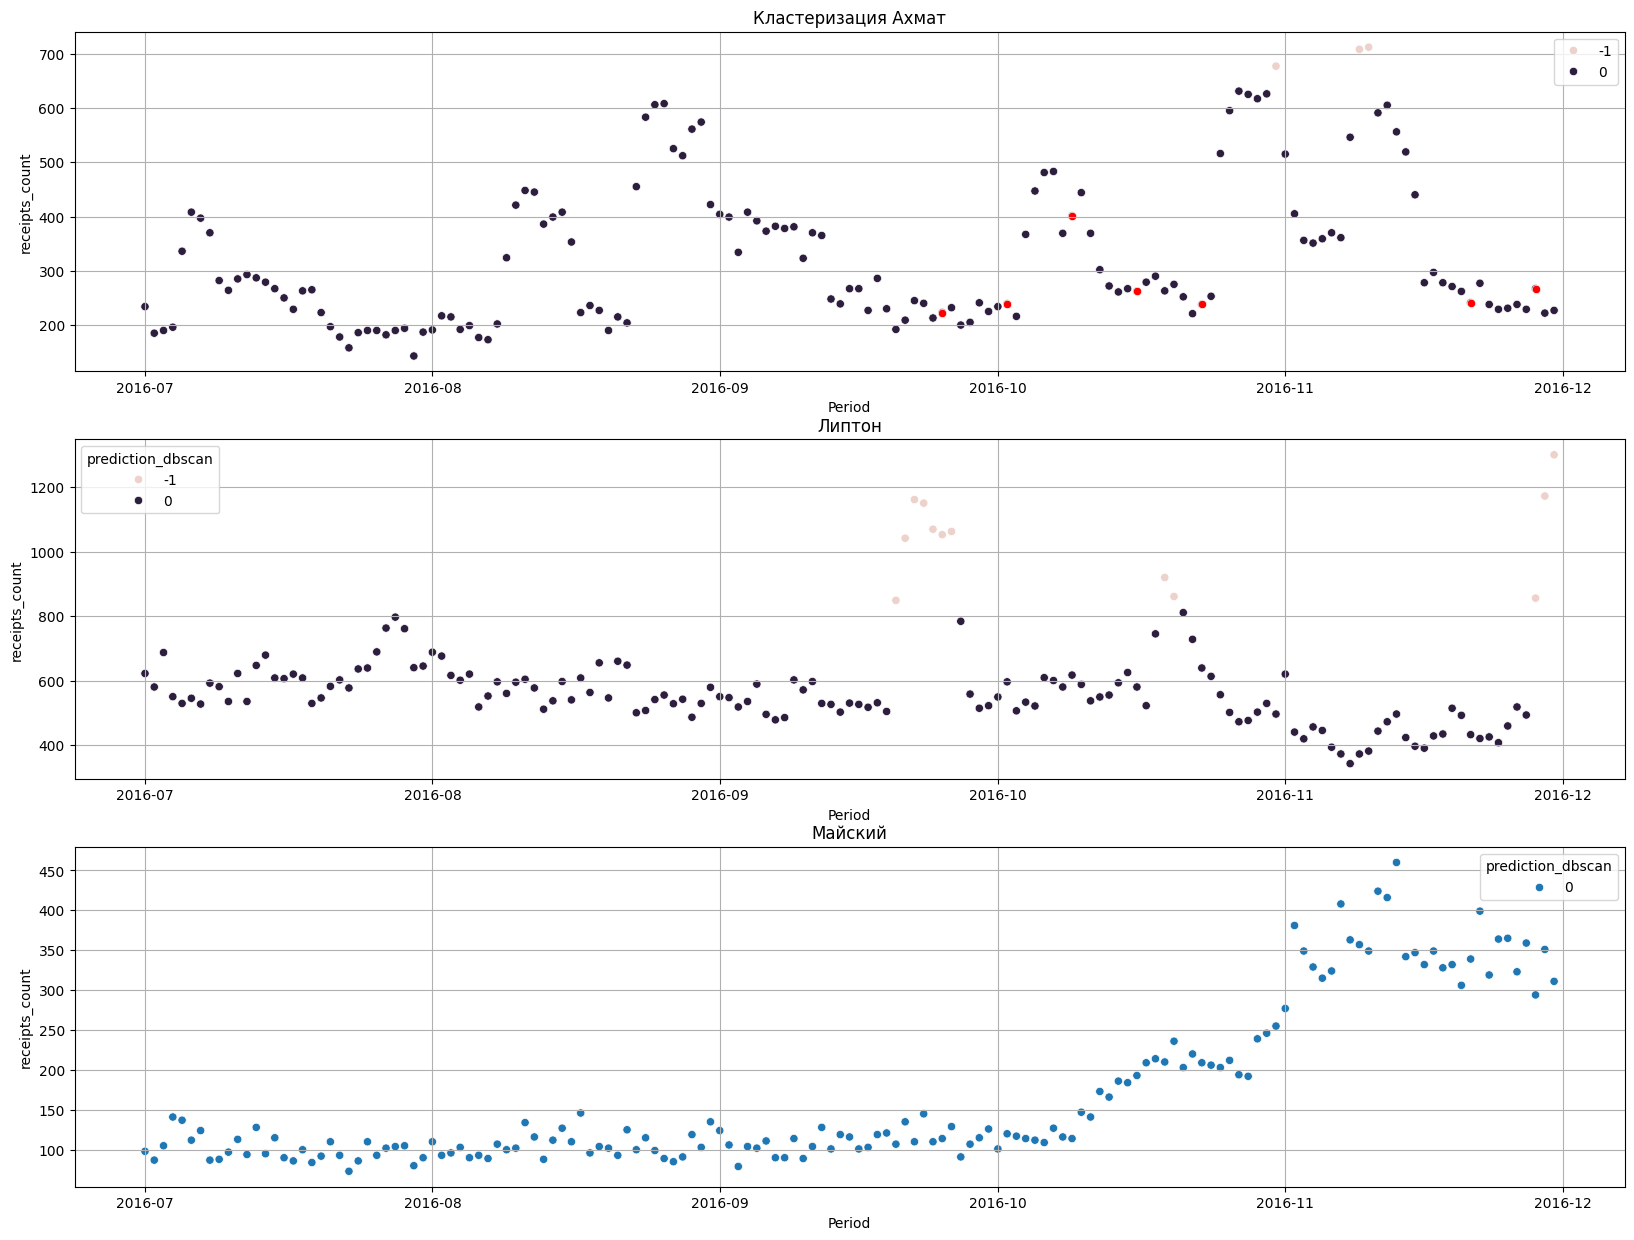

In [304]:
fig, axes = pyplot.subplots(nrows=3, figsize=(20, 15))

sns.scatterplot(y=data_ahmat.receipts_count, x=data_ahmat.date, hue=data_ahmat.prediction_dbscan, ax=axes[0])
sns.scatterplot(y=data_ahmat[data_ahmat.games==True].games*data_ahmat.receipts_count, x=data_ahmat.date, ax=axes[0], c='red')
axes[0].set(xlabel='Period', ylabel='receipts_count', title="Кластеризация Ахмат")
axes[0].grid()

sns.scatterplot(y=data_lipton.receipts_count, x=data_lipton.date, hue=data_lipton.prediction_dbscan, ax=axes[1])
axes[1].set(xlabel='Period', ylabel='receipts_count', title="Липтон")
axes[1].grid()

sns.scatterplot(y=data_may.receipts_count, x=data_may.date, hue=data_may.prediction_dbscan, ax=axes[2])
axes[2].set(xlabel='Period', ylabel='receipts_count', title="Майский")
axes[2].grid()

Методом кластеризации получилось три аномальных точки, но в период когда игры не проводились. На мой взгляд сами по себе аномальные точки должны свидетельствовать о кратковременном влиянии рекламной акции. При долговременном можно было бы наблюдать тренд как у Майского чая. Таким образом аномалии в период, когда игры не проводились не свидетельствуют о увеличении продаж.

## 6. Вывод

1. Исходя из построенной модели и сравнения медианных значений и модели реальных продаж, можно сказать, что долгосрочного влияния рекламная компания не возымела.  
2. Анализируя тренды в период проведения игр, коробчатая диаграмма не выявила аномалий. Метод кластеризации выявил три даты с аномальным количеством продаж. Однако эти даты выпадают на период, когда игры не проводились.  

**Вывод:**  
Из всего вышесказаного следует, что рекламная компания не имела влияния на продажи чая ахмат.